## QPEの簡単な例を実装する

では実際に、簡単な回路を使って量子位相推定を実装してみましょう。

まず、あるユニタリー演算$U$に対して$U|\psi\rangle=e^{2\pi i\theta}|\psi\rangle$となる固有ベクトル$|\psi\rangle$が必要ですが、ここでは$U$として1量子ビットの$S$ゲート（位相$\sqrt{Z}$ゲート）を考えてみます。$|1\rangle=\begin{pmatrix}0\\1\end{pmatrix}$として、$S|1\rangle=e^{i\pi/2}|1\rangle$となるので$|1\rangle$は$S$の固有ベクトル、$e^{i\pi/2}$がその固有値です。QPEは固有値$e^{2\pi i\theta}$の位相$\theta$を求めるので、$S$の場合は$\theta=1/4$を求めることに相当します。これを回路を使って実際に確かめてみます。

In [1]:
# Tested with python 3.8.12, qiskit 0.34.2, numpy 1.22.2
from fractions import Fraction
import matplotlib.pyplot as plt
import numpy as np
import math

from qiskit import IBMQ, QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile
from qiskit.providers.ibmq import least_busy, IBMQAccountCredentialsNotFound
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

# ワークブック独自のモジュール
import sys
sys.path.append('/home/jovyan/qc-workbook-lecturenotes/ja')
from qc_workbook.utils import operational_backend

In [12]:
n_meas = 3

# 位相測定用のレジスタ
qreg_meas = QuantumRegister(n_meas, name='meas')
# 固有ベクトルを保持するレジスタ
qreg_aux = QuantumRegister(1, name='aux')
# 位相測定の結果が書き出される古典レジスタ
creg_meas = ClassicalRegister(n_meas, name='out')

# 2つの量子レジスタと1つの古典レジスタから量子回路を作る
qc = QuantumCircuit(qreg_meas, qreg_aux, creg_meas)

# それぞれのレジスタを初期化
qc.h(qreg_meas)
qc.x(qreg_aux)

# angle/(2π)がQPEで求めたい位相
angle = np.pi / 2

# S = P(π/2)なので、(Controlled-S)^x を CP(xπ/2) で代替
for x, ctrl in enumerate(qreg_meas):
    qc.cp(angle * (2 ** x), ctrl, qreg_aux[0])

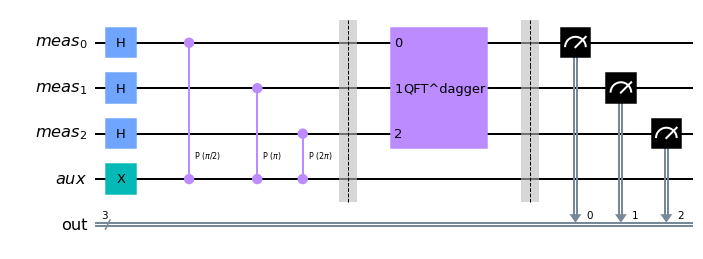

In [3]:
def qft_dagger(qreg):
    """逆量子フーリエ変換用の回路"""
    qc = QuantumCircuit(qreg)

    ##################
    ### EDIT BELOW ###
    ##################

    #qc?

    ##################
    ### EDIT ABOVE ###
    ##################

    qc.name = "QFT^dagger"
    return qc

qc.barrier()
qc.append(qft_dagger(qreg_meas), qargs=qreg_meas)
qc.barrier()
qc.measure(qreg_meas, creg_meas)
qc.draw('mpl')

### シミュレータでの実験

シミュレータで実行して、測定結果の確率分布を作ってみます。

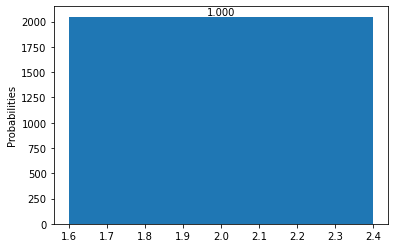

In [4]:
simulator = Aer.get_backend('aer_simulator')
shots = 2048
qc_tr = transpile(qc, backend=simulator)
results = simulator.run(qc_tr, shots=shots).result()
answer = results.get_counts()

def show_distribution(answer):
    n = len(answer)
    x = [int(key,2) for key in list(answer.keys())]
    y = list(answer.values())

    fig, ax = plt.subplots()
    rect = ax.bar(x,y)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.3f}'.format(height/sum(y)),
                        xy=(rect.get_x()+rect.get_width()/2, height),xytext=(0,0),
                        textcoords="offset points",ha='center', va='bottom')
    autolabel(rect)
    plt.ylabel('Probabilities')
    plt.show()

show_distribution(answer)

ここで見た量子回路はシンプルですが、いろいろ拡張して振る舞いを理解するのに役立ちます。例えば、以下の問題を調べてみてください。
- （グローバル因子を除いて）$S=R_Z(\pi/2)$ゲートの例を見ましたが、角度を$0<\phi<\pi$の範囲で変えた$R_Z(\phi)$ゲートではどうなるでしょうか？
- 角度の選び方によっては、得られる位相の精度が悪くなります。その場合、どうすればより良い精度で測定できるでしょうか？
- $S$ゲートの場合固有ベクトルは$|1\rangle$でしたが、$|1\rangle$以外の状態を使うとどうなりますか？特に固有ベクトルと線形従属なベクトルを使った場合の振る舞いを見てみてください。

### 量子コンピュータでの実験

最後に量子コンピュータで実行して、結果を確認してみましょう、以下のようにすることで、現時点でbusyでないマシンを優先的に選んで実行してくれます。

In [5]:
# 量子コンピュータで実行する場合
IBMQ.load_account()

try:
    provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='qc-training22')
except IBMQProviderError:
    provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

backend_list = provider.backends(filters=operational_backend(min_qubits=6))
backend = least_busy(backend_list)
print(f"least busy backend: {backend.name()}")

least busy backend:  ibm_kawasaki


In [6]:
# 最も空いているバックエンドで回路を実行します。キュー内のジョブの実行をモニターします。
qc_tr = transpile(qc, backend=backend, optimization_level=3)
job = backend.run(qc_tr, shots=shots)
job_monitor(job, interval=2)

Job Status: job has successfully run


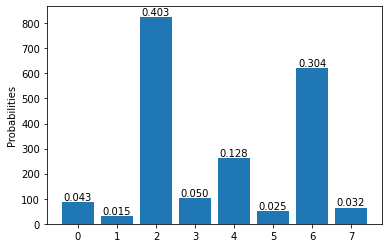

In [7]:
# 計算結果
results = job.result()
answer = results.get_counts()
show_distribution(answer)

## アルゴリズムの実装

ここから、ショアのアルゴリズムを実装していきます。

### 位数の発見

まず最初に、繰り返しの位数（周期）を発見するアルゴリズムを見てみます。

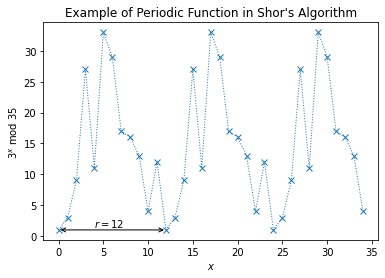

In [5]:
N = 35
a = 3

# プロットするデータを計算する
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# matplotlibを使って描画
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # グラフ上にrをプロット
    r = yvals[1:].index(1) + 1
    plt.annotate(text='', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='$r=%i$' % r, xy=(r/3,1.5))
except:
    print('Could not find period, check a < N and have no common factors.')

### オラクルの実装

In [6]:
def c_amod15(a, power):
    """mod 15による制御ゲート"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")

    U = QuantumCircuit(4)

    ##################
    ### EDIT BELOW ###
    ##################

    #U.?

    ##################
    ### EDIT ABOVE ###
    ##################

    # Uを2^l回繰り返す
    U_power = U.repeat(2 ** l)

    # U_powerをゲートに変換
    gate = U_power.to_gate()
    gate.name = f"{a}^{2 ** l} mod 15"

    # gateを制御ゲートに変換
    c_gate = gate.control()
    return c_gate

### 回路全体の実装

測定用ビットとして、8量子ビットを使います。

In [7]:
# 15と互いに素な数
a = 7

# 測定用ビットの数（位相推定の精度）
n_meas = 8

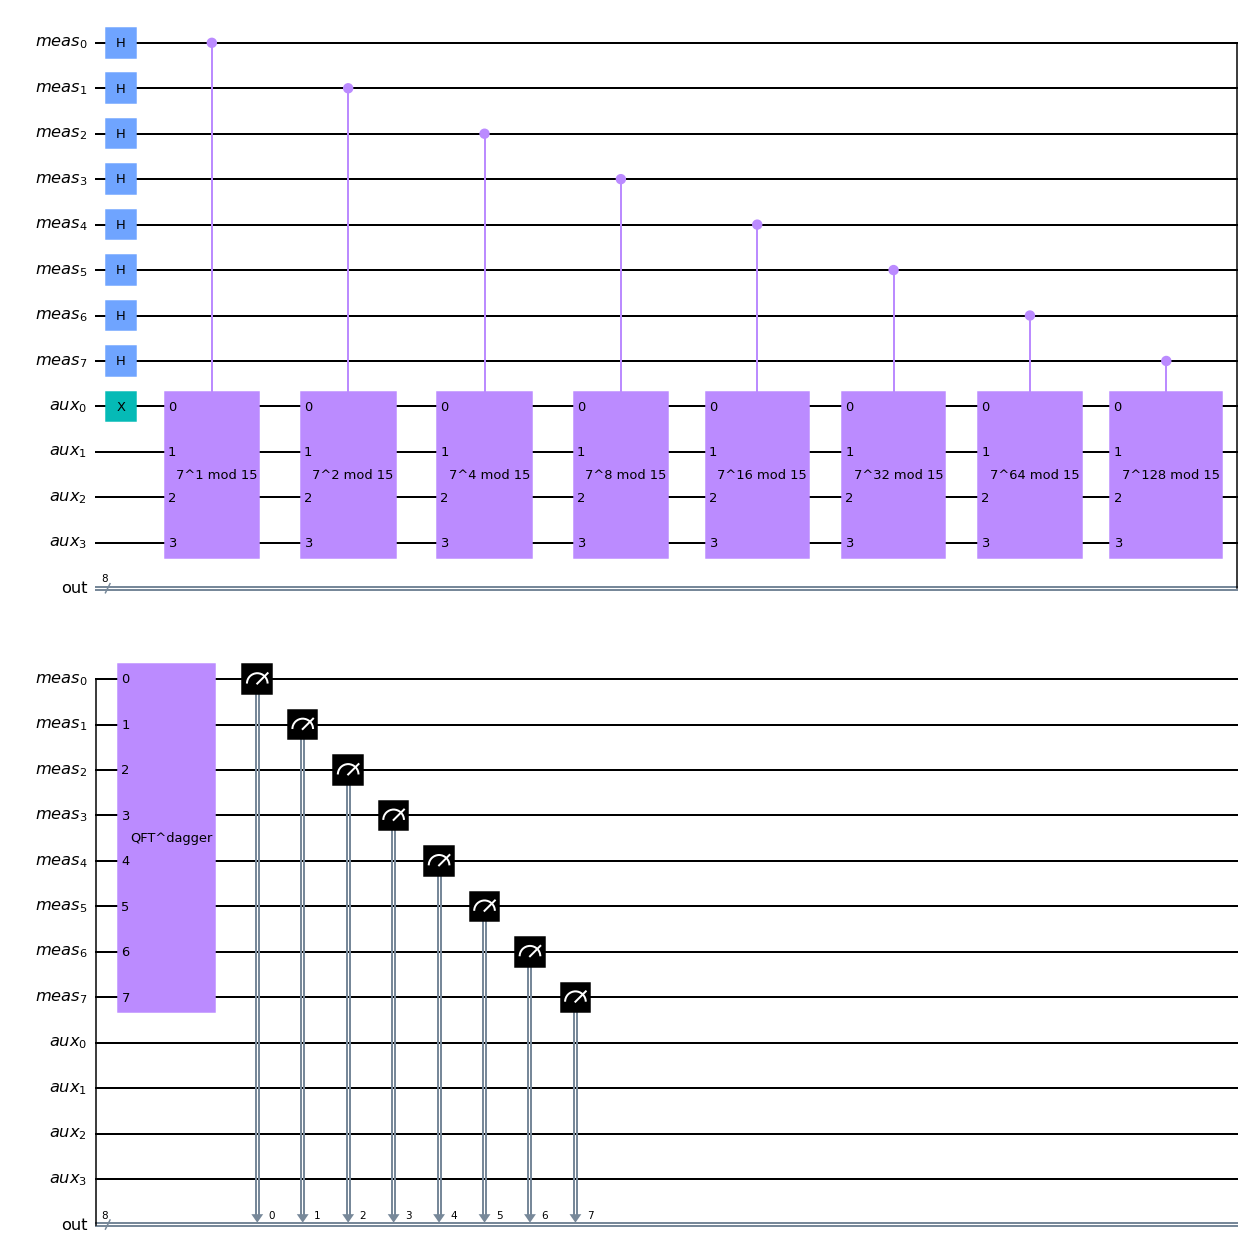

In [8]:
# 位相測定用のレジスタ
qreg_meas = QuantumRegister(n_meas, name='meas')
# Uを作用させる作業用レジスタ
qreg_aux = QuantumRegister(4, name='aux')
# 位相測定の結果が書き出される古典レジスタ
creg_meas = ClassicalRegister(n_meas, name='out')

# 2つの量子レジスタと1つの古典レジスタから量子回路を作る
qc = QuantumCircuit(qreg_meas, qreg_aux, creg_meas)

# 測定用レジスタをequal superpositionに初期化
qc.h(qreg_meas)
# 作業用レジスタを|1>に初期化
qc.x(qreg_aux[0])

# 制御Uゲートを適用
for l, ctrl in enumerate(qreg_meas):
    qc.append(c_amod15(a, l), qargs=([ctrl] + qreg_aux[:]))

# 逆QFTを適用
qc.append(qft_dagger(qreg_meas), qargs=qreg_meas)

# 回路を測定
qc.measure(qreg_meas, creg_meas)
qc.draw('mpl')

シミュレータで実行して、結果を確認してみます。

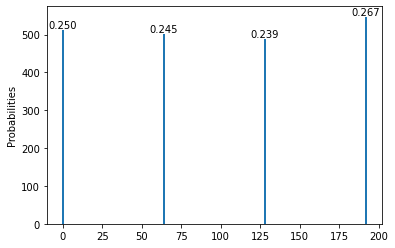

In [9]:
qc = transpile(qc, backend=simulator)
results = simulator.run(qc, shots=2048).result()
answer = results.get_counts()

show_distribution(answer)

### 計算結果の解析
出力された結果から、位相を求めてみます。

In [10]:
rows, measured_phases = [], []
for output in answer:
    decimal = int(output, 2)  # 10進数に変換
    phase = decimal / (2 ** n_meas)
    measured_phases.append(phase)
    # これらの値をテーブルの行に追加：
    rows.append(f"{decimal:3d}      {decimal:3d}/{2 ** n_meas} = {phase:.3f}")

# 結果を表示
print('Register Output    Phase')
print('------------------------')

for row in rows:
    print(row)

Register Output    Phase
------------------------
192      192/256 = 0.750
128      128/256 = 0.500
 64       64/256 = 0.250
  0        0/256 = 0.000


得られた位相の情報から、連分数アルゴリズムを使用して$s$と$r$を見つけることができます。Pythonの組み込みの`fractions`(分数)モジュールを使用して、小数を`Fraction`オブジェクトに変換できます。

In [11]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append(f'{phase:10.3f}      {frac.numerator:2d}/{frac.denominator:2d} {frac.denominator:13d}')

# 結果を表示
print('     Phase   Fraction   Guess for r')
print('-------------------------------------')

for row in rows:
    print(row)

     Phase   Fraction   Guess for r
-------------------------------------
     0.750       3/ 4             4
     0.500       1/ 2             2
     0.250       1/ 4             4
     0.000       0/ 1             1


limit_denominatorメソッドを使って、分母が特定の値（ここでは15）を下回る分数で、最も位相の値に近いものを得ています。

測定された結果のうち、2つ（64と192）が正しい答えである$r=4$を与えたことが分かります。

### コードの答え

逆量子フーリエ変換

In [ ]:
    ##################
    ### EDIT BELOW ###
    ##################

    # SWAPを忘れないように!
    for j in range(qreg.size // 2):
        qc.swap(qreg[j], qreg[-1 - j])

    for itarg in range(qreg.size):
        for ictrl in range(itarg):
            power = ictrl - itarg - 1
            qc.cp(-2. * np.pi * (2 ** power), ictrl, itarg)

        qc.h(itarg)

    ##################
    ### EDIT ABOVE ###
    ##################

オラクルの実装

In [ ]:
    ##################
    ### EDIT BELOW ###
    ##################

    if a in [2, 13]:
        # 下の位を上に移すので、上の位から順にSWAPしていく
        U.swap(3, 2)
        U.swap(2, 1)
        U.swap(1, 0)
    elif a in [4, 11]:
        # 「一つ飛ばし」のビットシフト
        U.swap(3, 1)
        U.swap(2, 0)
    elif a in [8, 7]:
        # 下から順
        U.swap(1, 0)
        U.swap(2, 1)
        U.swap(3, 2)

    if a in [7, 11, 13]:
        U.x([0, 1, 2, 3])

    ##################
    ### EDIT ABOVE ###
    ##################